In [39]:
import numpy as np
import pandas as pd 
import os
#import seaborn as sns
import matplotlib.pyplot as plt
#import seaborn as sns
#from tqdm import tqdm
from sklearn.model_selection import train_test_split

The data can be obtained from https://www.kaggle.com/c/dont-call-me-turkey

In [7]:
!pwd 

/home/jovyan/DeepAndShallowMusic


In [9]:
#!ls

 audio_files
'Audio SVD.ipynb'
 Chords_RBM.ipynb
 Data_Factorization-2.ipynb
 dont-call-me-turkey
'Feature_Extraction (librosa) -1.ipynb'
 Filtering.ipynb
'Finding_Structure (librosa)-3.ipynb'
 flow_tutorial.ipynb
 Fourier.ipynb
 gan_Chroma2Midi.ipynb
 GrammarMarkov.ipynb
 LZify.ipynb
 Midi-Audio-Lab.ipynb
 midi_manipulation.py
 midi_manipulation.pyc
 ML0120EN-1.1-Review-TensorFlow-Hello-World.ipynb
 ML0120EN-1.2-Exercise-LinearRegression-no-solutions.ipynb
 ML0120EN-1.2-Review-LinearRegressionwithTensorFlow.ipynb
 music21Intro.ipynb
'PCA with AE.ipynb'
 Phasors.ipynb
 Pop_Music_Midi
 Pretty-Midi.ipynb
 Pretty-Midi-Librosa-Tutorial.ipynb
 Read_Audio.ipynb
 rnn_midi.ipynb
 sample.mid
 sample.wav
'Spectrogram inversion.ipynb'
 Spectrogram.ipynb
'Stacked AE - STFT.ipynb'
 Tacotron2_and_WaveNet_text_to_speech_demo.ipynb
 test
'Turkey calls.ipynb'
 vae_midi.ipynb
 vmo_guided_music_synthesis.ipynb
'VMO-Intro copy.ipynb'
 VMO-Intro.ipynb


In [53]:
#cd ./dont-call-me-turkey  #change to the directory where you put the data

In [13]:
!ls ./dont-call-me-turkey

model.h5  model.json  sample_submission.csv  test.json	train.json


Other possible pretrained embeddings: L3open, EdgeL3, YAMnet
Can try also traditional audio features from librosa: spectrogram, melspect, mfcc

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
#from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,CuDNNLSTM, GRU, CuDNNGRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,LSTM, GRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras import backend as K
#from tensorflow.keras.engine.topology import Layer
from tensorflow.keras import initializers, regularizers, constraints
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [44]:
train = pd.read_json('./dont-call-me-turkey/train.json')
display(train.shape)

(1195, 5)

In [45]:
type(train)

pandas.core.frame.DataFrame

In [46]:
train.head()

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0


In [47]:
train_train, train_val = train_test_split(train, random_state = 42)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values
xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

In [48]:
x_train = pad_sequences(xtrain)
x_val = pad_sequences(xval, maxlen=10)
y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

In [49]:
mat = x_train[2]
type(x_train)
x_train[1].shape

(10, 128)

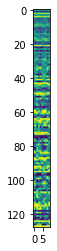

In [50]:
plt.figure(figsize=(2,4))
plt.imshow(mat.T)

In [56]:
model = Sequential()
model.add(BatchNormalization(momentum=0.98,input_shape=(10, 128)))
#model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model.add(Bidirectional(GRU(128, return_sequences = True)))
#model.add(Bidirectional(GRU(64, return_sequences = True)))
model.add(Bidirectional(GRU(64, return_sequences = False)))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = optimizers.Nadam(lr=0.001), metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 10, 128)           512       
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 256)           198144    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               123648    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 322,433
Trainable params: 322,177
Non-trainable params: 256
_________________________________________________________________
None


In [57]:
Winit = model.get_weights()

In [58]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [59]:
#fit on a portion of the training data, and validate on the rest
history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2)

Train on 896 samples, validate on 299 samples
Epoch 1/16
896/896 - 12s - loss: 0.5735 - accuracy: 0.7121 - val_loss: 0.5784 - val_accuracy: 0.7324
Epoch 2/16
896/896 - 2s - loss: 0.3285 - accuracy: 0.9230 - val_loss: 0.4754 - val_accuracy: 0.8395
Epoch 3/16
896/896 - 2s - loss: 0.2307 - accuracy: 0.9442 - val_loss: 0.3959 - val_accuracy: 0.8729
Epoch 4/16
896/896 - 2s - loss: 0.1749 - accuracy: 0.9520 - val_loss: 0.3362 - val_accuracy: 0.8863
Epoch 5/16
896/896 - 2s - loss: 0.1395 - accuracy: 0.9598 - val_loss: 0.2889 - val_accuracy: 0.8930
Epoch 6/16
896/896 - 2s - loss: 0.1201 - accuracy: 0.9643 - val_loss: 0.2582 - val_accuracy: 0.8896
Epoch 7/16
896/896 - 2s - loss: 0.1036 - accuracy: 0.9710 - val_loss: 0.2341 - val_accuracy: 0.8963
Epoch 8/16
896/896 - 2s - loss: 0.0920 - accuracy: 0.9699 - val_loss: 0.2188 - val_accuracy: 0.8963
Epoch 9/16
896/896 - 2s - loss: 0.0814 - accuracy: 0.9732 - val_loss: 0.2065 - val_accuracy: 0.9030
Epoch 10/16
896/896 - 2s - loss: 0.0720 - accuracy: 0

In [60]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
def plot_history(history):
    history_dict=history.history
    history_dict.keys()
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss_values, '-bo')
    # b+ is for "blue crosses"
    plt.plot(epochs, val_loss_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.figure()
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, acc_values, '-bo')
    plt.plot(epochs, val_acc_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

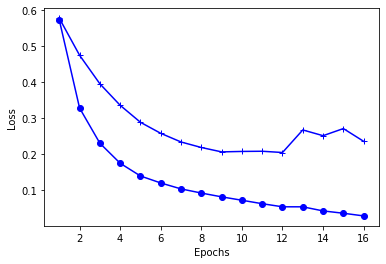

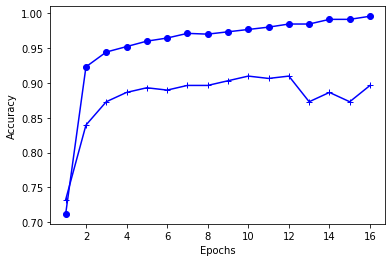

In [62]:
plot_history(history)

In [63]:
if 0:
    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")


### Early Stopping 

In [64]:
model.set_weights(Winit)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[early_stop])

Train on 896 samples, validate on 299 samples
Epoch 1/16
896/896 - 2s - loss: 0.5351 - accuracy: 0.7310 - val_loss: 0.5011 - val_accuracy: 0.8127
Epoch 2/16
896/896 - 2s - loss: 0.2342 - accuracy: 0.9453 - val_loss: 0.3913 - val_accuracy: 0.8863
Epoch 3/16
896/896 - 2s - loss: 0.1580 - accuracy: 0.9587 - val_loss: 0.3253 - val_accuracy: 0.8796
Epoch 4/16
896/896 - 2s - loss: 0.1359 - accuracy: 0.9576 - val_loss: 0.2944 - val_accuracy: 0.8896
Epoch 5/16
896/896 - 1s - loss: 0.1048 - accuracy: 0.9665 - val_loss: 0.2462 - val_accuracy: 0.9130
Epoch 6/16
896/896 - 2s - loss: 0.0885 - accuracy: 0.9754 - val_loss: 0.2250 - val_accuracy: 0.9130
Epoch 7/16
896/896 - 2s - loss: 0.0762 - accuracy: 0.9777 - val_loss: 0.2174 - val_accuracy: 0.8997
Epoch 8/16
896/896 - 2s - loss: 0.0732 - accuracy: 0.9788 - val_loss: 0.1993 - val_accuracy: 0.9197
Epoch 9/16
896/896 - 2s - loss: 0.0578 - accuracy: 0.9844 - val_loss: 0.1949 - val_accuracy: 0.9097
Epoch 10/16
896/896 - 1s - loss: 0.0474 - accuracy: 0.

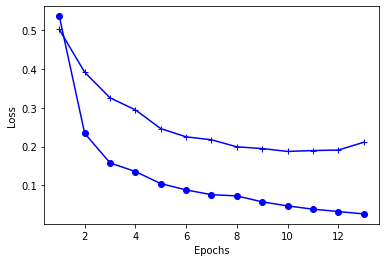

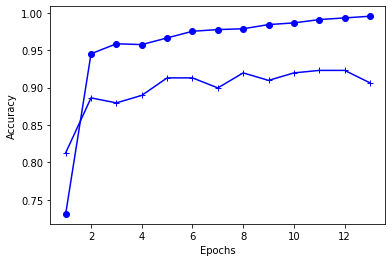

In [67]:
plot_history(history)

### Reduce Learning Rate

In [68]:
model.set_weights(Winit)

In [69]:
#early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_lr=1e-8)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[reduce_lr,early_stop])

Train on 896 samples, validate on 299 samples
Epoch 1/16
896/896 - 2s - loss: 0.5370 - accuracy: 0.7076 - val_loss: 0.4904 - val_accuracy: 0.8127
Epoch 2/16
896/896 - 1s - loss: 0.2198 - accuracy: 0.9453 - val_loss: 0.3816 - val_accuracy: 0.8829
Epoch 3/16
896/896 - 2s - loss: 0.1512 - accuracy: 0.9542 - val_loss: 0.3178 - val_accuracy: 0.8796
Epoch 4/16
896/896 - 2s - loss: 0.1185 - accuracy: 0.9643 - val_loss: 0.2698 - val_accuracy: 0.8997
Epoch 5/16
896/896 - 2s - loss: 0.1024 - accuracy: 0.9643 - val_loss: 0.2416 - val_accuracy: 0.9030
Epoch 6/16
896/896 - 2s - loss: 0.0884 - accuracy: 0.9688 - val_loss: 0.2234 - val_accuracy: 0.9064
Epoch 7/16
896/896 - 2s - loss: 0.0734 - accuracy: 0.9777 - val_loss: 0.2181 - val_accuracy: 0.8997
Epoch 8/16

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
896/896 - 2s - loss: 0.0643 - accuracy: 0.9777 - val_loss: 0.2061 - val_accuracy: 0.8997
Epoch 9/16
896/896 - 1s - loss: 0.0535 - accuracy: 0.9844 - val_loss: 0.

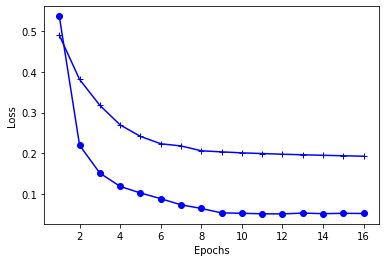

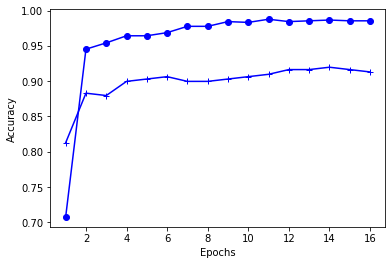

In [70]:
plot_history(history)

### ROC

In [71]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(yval, y_pred)

No handles with labels found to put in legend.


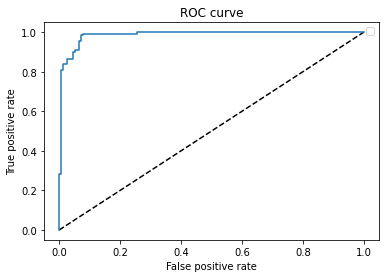

In [72]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr) # label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

For threshold 0.32230484 we get: tpr:  0.9014084507042254 fpr:  0.044585987261146494


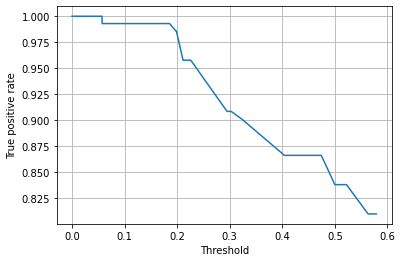

In [73]:
ind = [i for i, val in enumerate(tpr) if val>0.5] 
plt.plot(thresholds[ind],tpr[ind])
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('Threshold')
plt.ylabel('True positive rate')
plt.grid(b=True)

tpr_percentage = 0.90
indval = [i for i, val in enumerate(tpr) if val>=tpr_percentage]
print("For threshold", thresholds[indval[0]], "we get: tpr: ",tpr[indval[0]], "fpr: ", fpr[indval[0]])
threshold_percentage = thresholds[indval[0]]

In [74]:
#jdemonstrate the concept of tpr in terms of confusion matrix
from sklearn.metrics import confusion_matrix
yres = np.zeros(np.shape(yval))
yind = [i for i, res in enumerate(y_pred) if res >= threshold_percentage]
yres[yind] = 1
conf_mat = confusion_matrix(yval, yres)
tn, fp, fn, tp = conf_mat.ravel()
print("Confusion Matrix: \n ", conf_mat)
print("tpr from Confusion Matrix:", tp/(tp+fn))

Confusion Matrix: 
  [[150   7]
 [ 14 128]]
tpr from Confusion Matrix: 0.9014084507042254


#### About differences between accuracy and ROC check 

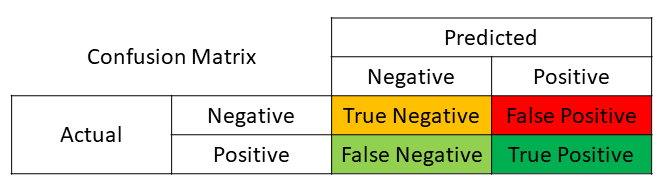


https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

### Classifier with alternative threshold

In [76]:
test = pd.read_json('./dont-call-me-turkey/test.json')
test.head()

,audio_embedding,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",pyKh38FXD3E,10,0
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",THhP1idrWXA,40,30
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",jsw3T6GY2Nw,40,30
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",nFkXTMHcjMU,24,14
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",Au8g9kAlrLQ,40,30


In [77]:
xtest = [k for k in test['audio_embedding']]
x_test = pad_sequences(xtest)

In [78]:
results = model.predict(np.array(x_test))
results[0]

array([0.00283039], dtype=float32)

In [79]:
#yres = [1 for i, res in enumerate(results) if res > threshold_percentage]

for i, res in enumerate(results[0:10]):
    if res > threshold_percentage:
        print(i, ': Call me turkey')
    else:
        print(i, ': Don\'t call me turkey')
        

0 : Don't call me turkey
1 : Don't call me turkey
2 : Don't call me turkey
3 : Don't call me turkey
4 : Call me turkey
5 : Don't call me turkey
6 : Don't call me turkey
7 : Don't call me turkey
8 : Call me turkey
9 : Call me turkey
